In [1]:
import datetime
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests

In [17]:
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN', 'GOOG', 'MSFT', 'NFLX', 'AMD', 'ADBE', 'NVDA', 'INTC', 'PYPL', 'CSCO']
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    resp = requests.get(url, headers={'User-Agent':'Mozilla/5.0'} )
    resp = resp.text
  
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
 
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            # if i == n-1:
            #     break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Apple's top U.S. App Store apps and games for 2023 ( Today 11:58AM )
Best Dow Jones Stocks To Buy And Watch In December 2023: Apple At Buy Point ( 11:55AM )
Apple to Support RCS, The Real  Why  Behind iMessage's U.S. Superiority, EU Leaning Against Regulating iMessage ( 11:37AM )
10 A-Rated Stocks Billionaires Are Loading Up On ( 11:22AM )
iPhone 17 Pro will get TSMC's first 2nm chips ( 11:18AM )
What Google's antitrust loss to Epic Games means for tech ( 10:22AM )
Why the Google-Epic Games Decision Is Bad News for Apple and the Rest of Big Tech ( 10:09AM )
More on Apple Share Buyback vs. Market Cap, Thoughts on Apple and a $4 Trillion Market Cap, Thursday Q&A ( 09:32AM )
Apple Inc. (AAPL) Is a Trending Stock: Facts to Know Before Betting on It ( 09:00AM )
Warren Buffett and Billionaires Are Crazy About These 5 Stocks ( 08:52AM )
How to film Spatial Video for Apple Vision Pro on iPhone 15 Pro ( 08:46AM )
Google Lost Against Epic Games, Apple Won. Why 

In [18]:
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])


analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [19]:
for i in range(len(news['Date'])):
    date = news['Date'][i]
    if date == 'Today':
        date = datetime.datetime.now().strftime('%Y-%m-%d')
    else:
        date = datetime.datetime.strptime(date, '%b-%d-%y').strftime('%Y-%m-%d')
    news.loc[i, 'Date'] = date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)



              Date     Time  neg    neu    pos  compound
Ticker                                                  
AAPL    2023-12-12  11:58AM  0.0  0.833  0.167    0.2023
AAPL    2023-12-12  11:55AM  0.0  0.769  0.231    0.6369
AAPL    2023-12-12  11:37AM  0.0  0.733  0.267    0.6249
AAPL    2023-12-12  11:22AM  0.0  1.000  0.000    0.0000
AAPL    2023-12-12  11:18AM  0.0  1.000  0.000    0.0000


              Date     Time    neg    neu    pos  compound
Ticker                                                    
TSLA    2023-12-12  12:20PM  0.241  0.759  0.000   -0.5423
TSLA    2023-12-12  11:44AM  0.000  1.000  0.000    0.0000
TSLA    2023-12-12  11:43AM  0.292  0.708  0.000   -0.3182
TSLA    2023-12-12  11:07AM  0.000  1.000  0.000    0.0000
TSLA    2023-12-12  10:35AM  0.000  0.776  0.224    0.3818


              Date     Time    neg    neu    pos  compound
Ticker                                                    
AMZN    2023-12-12  11:30AM  0.000  1.000  0.000    0.0000
AMZN 

In [20]:
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
# Define a function to map compound scores to emotions
def map_to_emotion(compound_score):
    if compound_score > 0.05:
        return 'Positive'
    elif -0.05 <= compound_score <= 0.05:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the mapping function to the 'Mean Sentiment' column
df['Emotion'] = df['Mean Sentiment'].map(map_to_emotion)

# Display the updated DataFrame
print ('\n')
print (df)



        Mean Sentiment   Emotion
Ticker                          
NVDA              0.26  Positive
AMZN              0.20  Positive
MSFT              0.20  Positive
NFLX              0.17  Positive
ADBE              0.16  Positive
PYPL              0.15  Positive
AMD               0.14  Positive
INTC              0.12  Positive
GOOG              0.11  Positive
AAPL              0.08  Positive
TSLA              0.08  Positive
CSCO              0.07  Positive


               neg          neu          pos     compound
count  1200.000000  1200.000000  1200.000000  1200.000000
mean      0.044808     0.826158     0.129034     0.143871
std       0.094366     0.166554     0.153310     0.336654
min       0.000000     0.283000     0.000000    -0.844200
25%       0.000000     0.702000     0.000000     0.000000
50%       0.000000     0.825000     0.000000     0.000000
75%       0.000000     1.000000     0.244000     0.401900
max       0.495000     1.000000     0.667000     0.915300


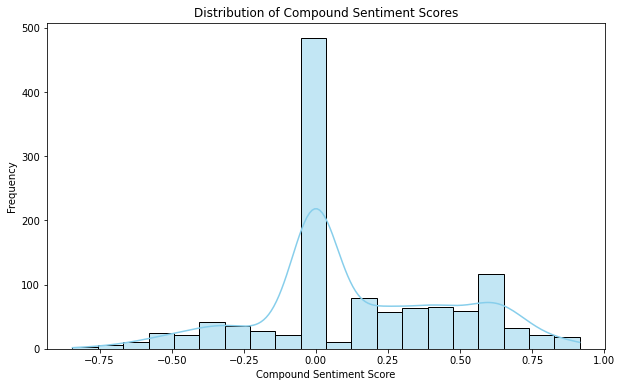

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display summary statistics of sentiment scores
print(news.describe())

# Distribution of compound sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(news['compound'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

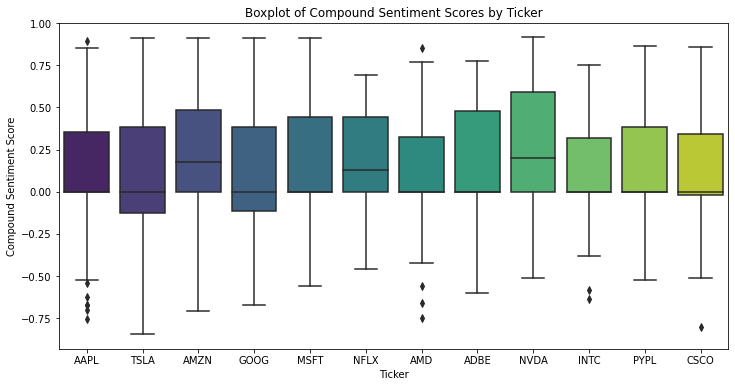

In [22]:

# Boxplot of compound sentiment scores by Ticker
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ticker', y='compound', data=news, palette='viridis')
plt.title('Boxplot of Compound Sentiment Scores by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Compound Sentiment Score')
plt.show()


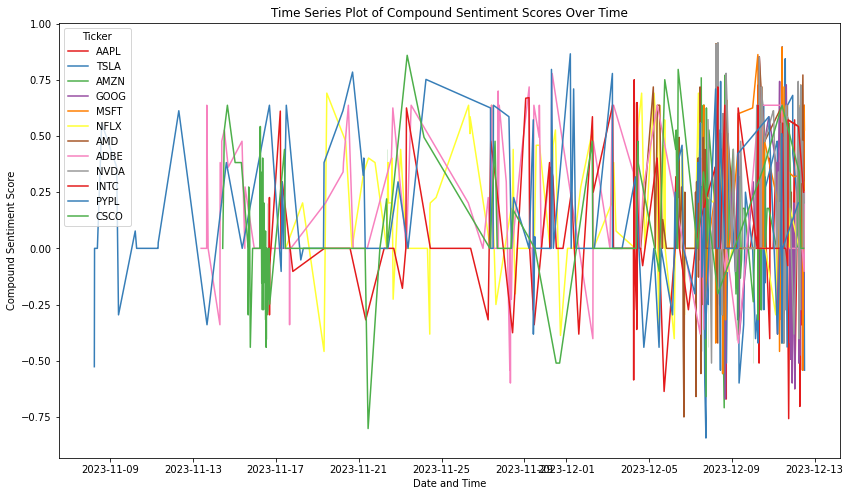

In [23]:
# Time series plot of compound sentiment scores over time
news['DateTime'] = pd.to_datetime(news['Date'] + ' ' + news['Time'])
plt.figure(figsize=(14, 8))
sns.lineplot(x='DateTime', y='compound', hue='Ticker', data=news, palette='Set1')
plt.title('Time Series Plot of Compound Sentiment Scores Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Compound Sentiment Score')
plt.show()


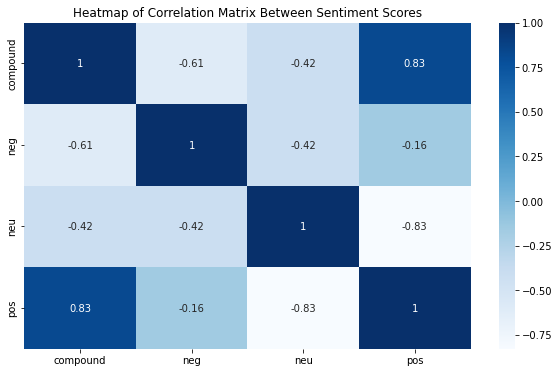

In [24]:
# Heatmap of correlation matrix between sentiment scores
correlation_matrix = news[['compound', 'neg', 'neu', 'pos']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Heatmap of Correlation Matrix Between Sentiment Scores')
plt.show()


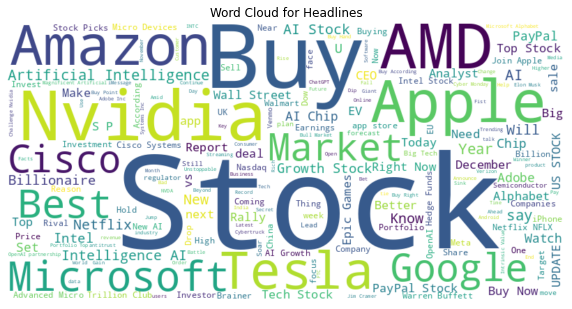

In [25]:
from wordcloud import WordCloud

# Combine headlines for each ticker
text = ' '.join(news['Headline'])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Headlines')
plt.show()


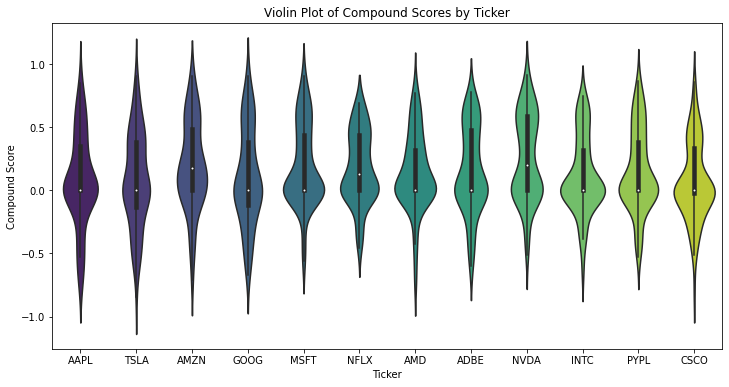

In [30]:
# Violin plot of Compound Scores by Ticker
plt.figure(figsize=(12, 6))
sns.violinplot(x='Ticker', y='compound', data=news, palette='viridis')
plt.title('Violin Plot of Compound Scores by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Compound Score')
plt.show()


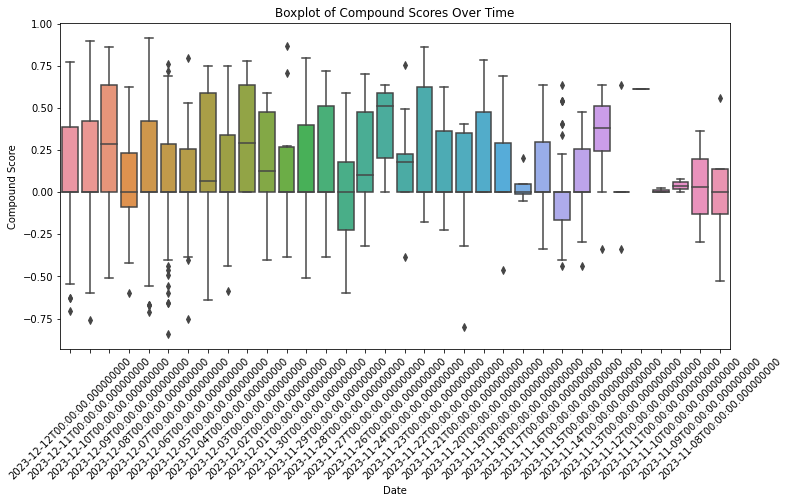

In [31]:
# Boxplot of Compound Scores Over Time
plt.figure(figsize=(12, 6))
sns.boxplot(x='Date', y='compound', data=news)
plt.title('Boxplot of Compound Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Score')
plt.xticks(rotation=45)
plt.show()


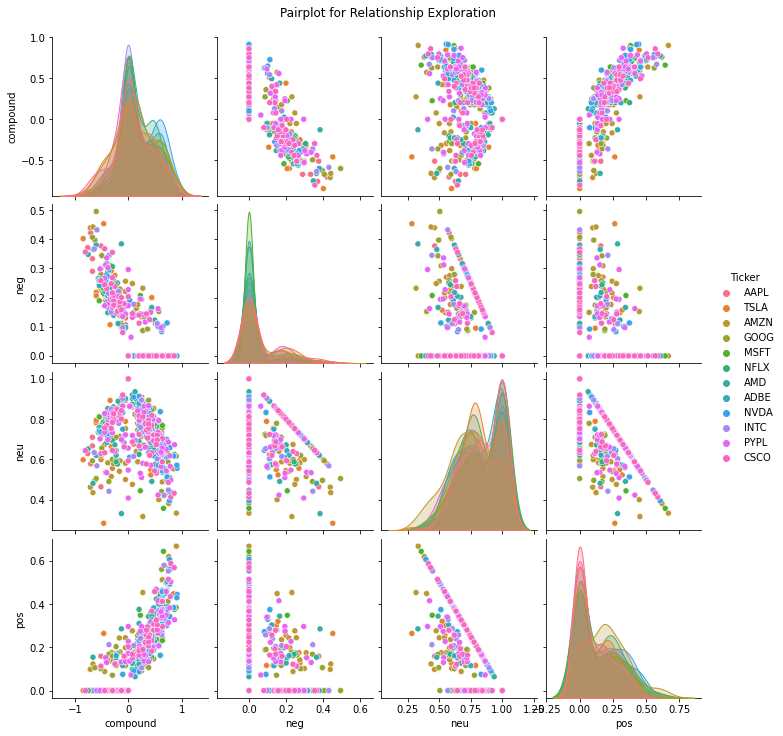

In [32]:
# Pairplot for Relationship Exploration
sns.pairplot(news, hue='Ticker', vars=['compound', 'neg', 'neu', 'pos'])
plt.suptitle('Pairplot for Relationship Exploration', y=1.02)
plt.show()


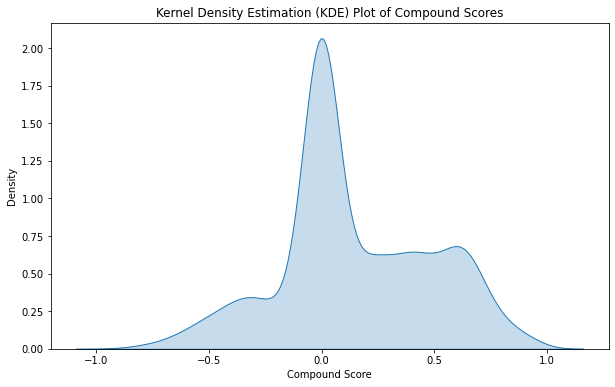

In [33]:
# KDE Plot of Compound Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df_scores['compound'], shade=True)
plt.title('Kernel Density Estimation (KDE) Plot of Compound Scores')
plt.xlabel('Compound Score')
plt.show()
